### This jupyter notebook is to test the SVM-Regression Model for predicting Fords price using data from yahoo finance

In [83]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

## import model objects
from sklearn.model_selection import train_test_split
import yfinance as yf
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [84]:
df= pd.read_csv("dataset_reg.csv")

In [85]:
# Add date as a column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [86]:
df.head()

,Date,CADUSD=X_Open,CADUSD=X_Close,CADUSD=X_High,CADUSD=X_Low,CADUSD=X_Volume,CADUSD=X_Change,CADUSD=X_Gain,CADUSD=X_Loss,CADUSD=X_Avg_Gain,...,F_change_in_price,F_RSI,F_k_percent,F_r_percent,F_MACD,F_MACD_EMA,F_ROC,F_PVT,F_Bollinger_Upper,F_Bollinger_Lower
0,2019-12-12 00:00:00+00:00,0.759169,0.759146,0.759878,0.758058,0,0.003345,0.003345,0.00000,0.001068,...,0.210000,79.634870,93.220336,-6.779664,0.044498,0.022817,3.555552,2.126954e+06,9.246596,8.693404
1,2019-12-13 00:00:00+00:00,0.760323,0.760300,0.760341,0.757363,0,0.001154,0.001154,0.00000,0.001054,...,-0.090000,67.259540,72.881227,-27.118773,0.051915,0.028691,2.441724,1.785741e+06,9.278143,8.705857
2,2019-12-16 00:00:00+00:00,0.758426,0.758530,0.762602,0.758426,0,-0.001770,0.000000,0.00177,0.001054,...,0.160001,75.173527,100.000000,-0.000000,0.067770,0.036565,3.186813,2.519657e+06,9.349882,8.678118
3,2019-12-17 00:00:00+00:00,0.759728,0.759705,0.760688,0.758443,0,0.001175,0.001175,0.00000,0.001137,...,0.000000,75.173527,96.721391,-3.278609,0.079264,0.045155,3.642383,2.519657e+06,9.409738,8.662262
4,2019-12-18 00:00:00+00:00,0.759821,0.759925,0.763202,0.759031,0,0.000219,0.000219,0.00000,0.001015,...,0.150000,80.927645,96.103928,-3.896072,0.097567,0.055687,5.882350,3.252967e+06,9.498060,8.637940


In [87]:
df.dtypes

Date                 datetime64[ns, UTC]
CADUSD=X_Open                    float64
CADUSD=X_Close                   float64
CADUSD=X_High                    float64
CADUSD=X_Low                     float64
                            ...         
F_MACD_EMA                       float64
F_ROC                            float64
F_PVT                            float64
F_Bollinger_Upper                float64
F_Bollinger_Lower                float64
Length: 152, dtype: object

In [88]:
df.describe()

,CADUSD=X_Open,CADUSD=X_Close,CADUSD=X_High,CADUSD=X_Low,CADUSD=X_Volume,CADUSD=X_Change,CADUSD=X_Gain,CADUSD=X_Loss,CADUSD=X_Avg_Gain,CADUSD=X_Avg_Loss,...,F_change_in_price,F_RSI,F_k_percent,F_r_percent,F_MACD,F_MACD_EMA,F_ROC,F_PVT,F_Bollinger_Upper,F_Bollinger_Lower
count,1238.000000,1238.000000,1238.000000,1238.000000,1238.0,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,...,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1.238000e+03,1238.000000,1238.000000
mean,0.758303,0.758307,0.760400,0.756045,0.0,-0.000030,0.001220,0.001250,0.001219,0.001247,...,0.001607,50.626409,49.552385,-50.447615,0.010158,0.010202,0.704309,9.813649e+07,13.138726,10.883199
std,0.028493,0.028490,0.028557,0.028480,0.0,0.003274,0.001930,0.001987,0.000541,0.000645,...,0.343786,17.263592,30.445638,30.445638,0.421307,0.395357,10.287743,6.145532e+07,3.927067,3.127711
min,0.690026,0.689741,0.693371,0.681826,0.0,-0.012518,0.000000,0.000000,0.000048,0.000016,...,-2.510000,8.699250,0.000000,-100.000000,-1.071207,-0.953758,-40.504446,-8.463164e+07,5.333265,3.663582
25%,0.735749,0.735749,0.737485,0.733942,0.0,-0.001902,0.000000,0.000000,0.000858,0.000816,...,-0.150001,39.132810,22.524929,-77.475071,-0.207953,-0.203145,-5.120935,6.443174e+07,11.190601,9.223954
50%,0.751010,0.750993,0.753049,0.748901,0.0,-0.000025,0.000000,0.000025,0.001170,0.001164,...,0.000000,49.944425,48.661757,-51.338243,-0.000049,0.007805,0.136480,1.155039e+08,13.085862,11.187365
75%,0.783627,0.783562,0.786046,0.780634,0.0,0.001852,0.001852,0.001902,0.001553,0.001510,...,0.160001,63.226813,78.001716,-21.998284,0.241311,0.230676,6.645445,1.356447e+08,14.864209,12.243559
max,0.830599,0.830703,0.832778,0.829009,0.0,0.012381,0.012381,0.012518,0.003353,0.004876,...,2.539999,92.692054,100.000000,-0.000000,1.382432,1.213766,38.490564,2.314456e+08,26.710337,19.065638


In [89]:
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(months=2)
df_last_2_months = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Step 2: Prepare features (X) and target (y)
X = df_last_2_months.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
y = df_last_2_months['F_Close_pred']

In [90]:
# Standardize and remove skewness
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
power_transformer = PowerTransformer()
X_transformed = power_transformer.fit_transform(X_scaled)

In [91]:
# Split data - keep the last 1 week as an unseen test set
split_index = len(X_transformed) - 7
X_train_val, X_unseen_test = X_transformed[:split_index], X_transformed[split_index:]
y_train_val, y_unseen_test = y[:split_index], y[split_index:]

In [92]:
print(np.isnan(X_train_val).sum())  # Check for NaN in training data
print(np.isnan(X_unseen_test).sum())   # Check for NaN in test data

0
0


In [93]:
# Perform train-test split
tscv = TimeSeriesSplit(n_splits=5)

In [94]:
# Deftine the parameter grid for grid search
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [1, 10, 50, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}
svr = SVR()

grid_search = GridSearchCV(svr, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_val, y_train_val)
best_params = grid_search.best_params_
# Train the model with the best parameters
best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train_val, y_train_val)
## Make predictions: on the test set (i.e. last week)
predictions = best_svr_model.predict(X_unseen_test)
mse = mean_squared_error(y_unseen_test,predictions)

In [95]:
print("Best Hyperparameters",best_params)
print("Mean Squared Error",mse)

Best Hyperparameters {'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}
Mean Squared Error 0.10761235023018015


In [96]:
# Chosen model
modelSVR = SVR(kernel='linear', C=1, epsilon=0.01)

In [97]:
# checking 
modelSVR.fit(X_train_val, y_train_val)
## Make predictions: on the test set (i.e. last week)
predictions = best_svr_model.predict(X_unseen_test)
mse = mean_squared_error(y_unseen_test,predictions)
print("Mean Squared Error",mse)

Mean Squared Error 0.10761235023018015


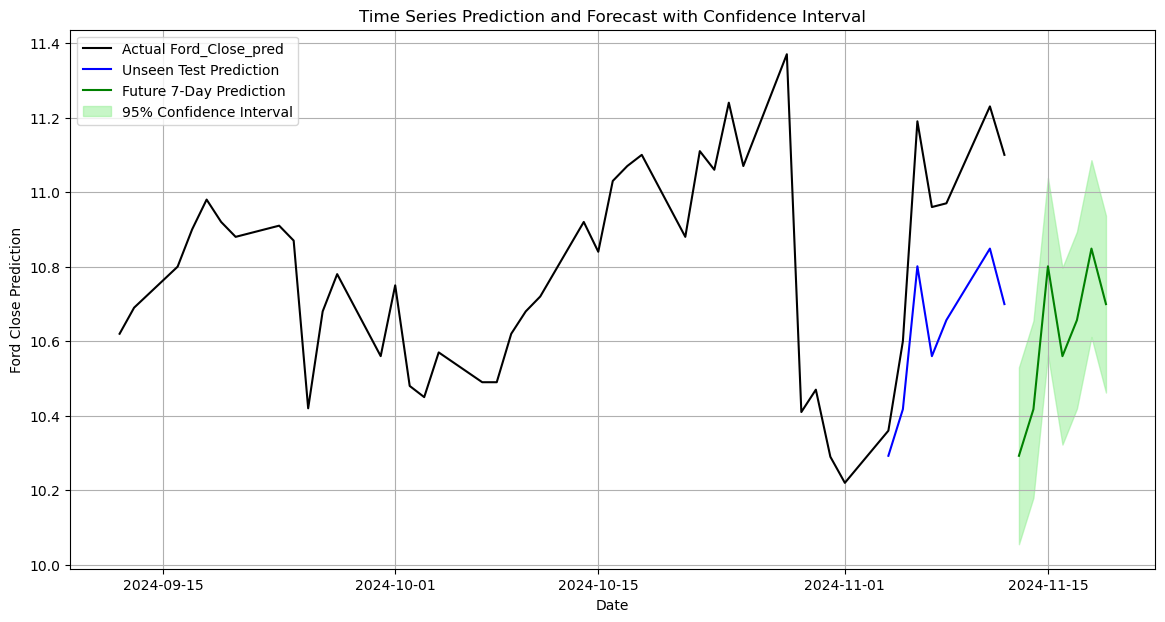

In [98]:
# Step 7: Forecast the next 7 days with a confidence interval
z = 7
future_7_days = X_transformed[-z:]  # Use the last week for forecasting
future_predictions = modelSVR.predict(future_7_days)
# Calculate confidence interval (simple approximation based on prediction standard deviation)
std_dev = np.std(predictions - y_unseen_test)
upper_bound = future_predictions + (1.96 * std_dev)
lower_bound = future_predictions - (1.96 * std_dev)

# # Plot the results
plt.figure(figsize=(14, 7))
# Actual data
plt.plot(df_last_2_months['Date'], y, label="Actual Ford_Close_pred", color='black')
# Predictions on unseen test
plt.plot(df_last_2_months['Date'].iloc[-z:], predictions, label="Unseen Test Prediction", color='blue')
# Future forecast
future_dates = pd.date_range(df_last_2_months['Date'].iloc[-1] + pd.Timedelta(days=1), periods=z)
plt.plot(future_dates, future_predictions, label="Future 7-Day Prediction", color='green')
plt.fill_between(future_dates, lower_bound, upper_bound, color='lightgreen', alpha=0.5, label="95% Confidence Interval")

plt.xlabel("Date")
plt.ylabel("Ford Close Prediction")
plt.title("Time Series Prediction and Forecast with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

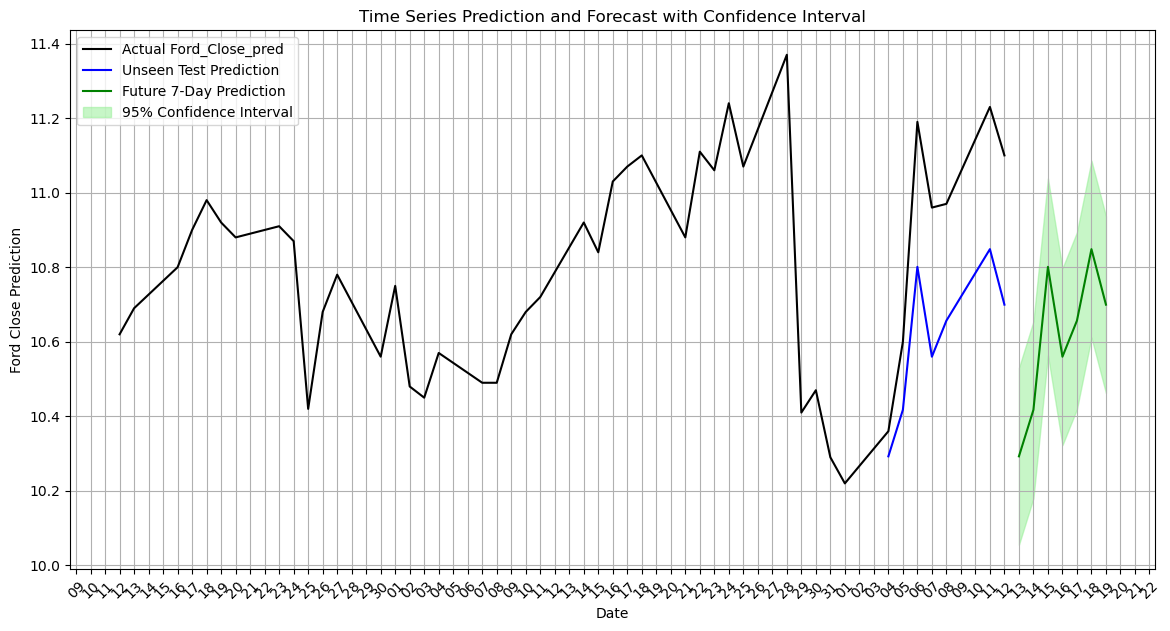

In [99]:
import matplotlib.dates as mdates

# Step 7: Forecast the next 7 days with a confidence interval
z = 7
future_7_days = X_transformed[-z:]  # Use the last week for forecasting
future_predictions = modelSVR.predict(future_7_days)

# Calculate confidence interval (simple approximation based on prediction standard deviation)
std_dev = np.std(predictions - y_unseen_test)
upper_bound = future_predictions + (1.96 * std_dev)
lower_bound = future_predictions - (1.96 * std_dev)

# Plot the results
plt.figure(figsize=(14, 7))

# Actual data
plt.plot(df_last_2_months['Date'], y, label="Actual Ford_Close_pred", color='black')

# Predictions on unseen test
plt.plot(df_last_2_months['Date'].iloc[-z:], predictions, label="Unseen Test Prediction", color='blue')

# Future forecast for the next 7 days
future_dates = pd.date_range(df_last_2_months['Date'].iloc[-1] + pd.Timedelta(days=1), periods=z)
plt.plot(future_dates, future_predictions, label="Future 7-Day Prediction", color='green')
plt.fill_between(future_dates, lower_bound, upper_bound, color='lightgreen', alpha=0.5, label="95% Confidence Interval")

# Plot styling
plt.xlabel("Date")
plt.ylabel("Ford Close Prediction")
plt.title("Time Series Prediction and Forecast with Confidence Interval")
plt.legend()
plt.grid(True)

# Set grid for each day and format date to show only the day
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Major grid lines for each day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # Format x-axis labels by day only
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

plt.show()


## Backtesting

In [100]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Parameters
window_size = 50  # Number of days in training window
test_size = 10    # Number of days in testing window

# Initialize variables
mse_scores = []
mape_scores = []

# Perform rolling window backtesting
for start in range(0, len(X_transformed) - window_size - test_size, test_size):
    # Define training and testing sets
    train_X = X_transformed[start:start + window_size]
    train_y = y[start:start + window_size]
    test_X = X_transformed[start + window_size:start + window_size + test_size]
    test_y = y[start + window_size:start + window_size + test_size]

    # Train the SVR model
    model = SVR(kernel='linear', C=1, epsilon=0.01)  # Use the best hyperparameters
    model.fit(train_X, train_y)

    # Predict on the test set
    predictions = model.predict(test_X)

    # Evaluate the model
    mse = mean_squared_error(test_y, predictions)
    mape = mean_absolute_percentage_error(test_y, predictions)

    mse_scores.append(mse)
    mape_scores.append(mape)

# Print backtesting results
print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average MAPE: {np.mean(mape_scores) * 100:.2f}%")


Average MSE: nan
Average MAPE: nan%


/opt/anaconda3/envs/stock_vs_commodity/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/stock_vs_commodity/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


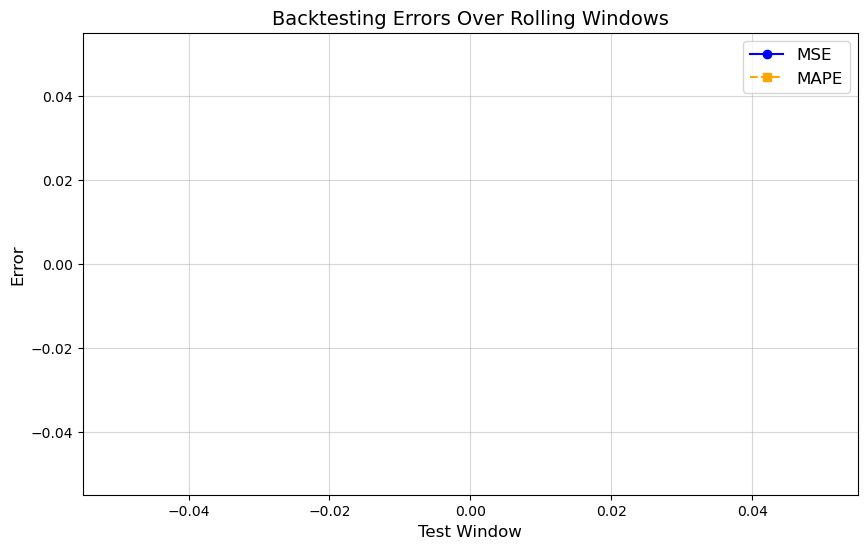

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
plt.plot(range(len(mse_scores)), mse_scores, label="MSE", marker='o', linestyle='-', color='blue')
plt.plot(range(len(mape_scores)), mape_scores, label="MAPE", marker='s', linestyle='--', color='orange')
plt.xlabel("Test Window", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.title("Backtesting Errors Over Rolling Windows", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)  # Add grid with transparency
plt.show()


In [106]:
mse_scores = []
mape_scores = []
epsilon = 1e-6 

for train_index, test_index in tscv.split(X_train_val):
    # Training and testing data
    X_train, X_test = X_train_val[train_index], X_train_val[test_index]
    y_train, y_test = y_train_val[train_index], y_train_val[test_index]

    # Ensure data is valid
    if len(X_train) == 0 or len(X_test) == 0:
        print("Empty train or test set encountered. Check your rolling window logic.")
        continue

    # Fit model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate errors
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100

    mse_scores.append(mse)
    mape_scores.append(mape)
    if mse_scores:
        average_mse = np.mean(mse_scores)
    else:
        print("MSE scores are empty.")
        average_mse = None


KeyError: "None of [Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')] are in the [index]"